# Linear Regression Test
This is a test to use the scikit-learn's LinearRegression to model the amount of filament used per minute of the cohort class Edison+ 3D Printer.

### Import Dependencies


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import csv

%run 'preprocessor.ipynb' #our own preprocessor functions

### Prepare Dataset

In [4]:
with open('data_w1w4.csv', 'r') as f:
      reader = csv.reader(f)
      data = list(reader)
    
matrix = obtain_data_matrix(data)
samples = len(matrix)
print("Number of samples: " + str(samples))

Y = matrix[:,[8]]
X = matrix[:,[9]]

Number of samples: 164


### Use the model (LinearRegression)

In [5]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X, Y)

# Make predictions using the testing set
Y_pred = regr.predict(X)

### Plot the data

Coefficients:  [[ 0.08275334]]


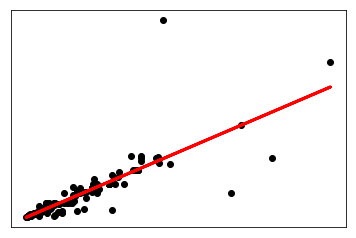

Mean squared error: 130.31
Variance score: 0.70


In [13]:
plt.scatter([X], [Y],  color='black')
plt.plot(X, Y_pred, color='red', linewidth=3)

plt.xticks(())
plt.yticks(())

print('Coefficients: ', regr.coef_)

plt.show()

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y, Y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y, Y_pred))